# World Value Survey Machine Learning #
The purpose of this project is to create models that are able to explain the variable V23 in the United States.
This is the wording of the V23 questions: <br> <i>"All things considered, how satisfied are you with your life as a whole these days? Using this card on
which 1 means you are “completely dissatisfied” and 10 means you are “completely satisfied”
where would you put your satisfaction with your life as a whole?" </i> <br>

Essentially I am looking at what is important to people's life satisfcation in the United States. You can find more information about the survey at the link <a href="http://www.worldvaluessurvey.org/wvs.jsp">here. </a>

In [47]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go

from factor_analyzer import FactorAnalyzer, analyze
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score

In [2]:
# read in dataset from the World Values Survey
df = pd.read_csv('data/WV6_Data_CSV.csv')

In [3]:
#How big is the dataframe?
df.shape

(89565, 440)

### Countries ### 
The countries would have a lot of different aspects or perspectives on predicting life satisfaction. Like I mentioned I am first focusing on the United States. 

In [4]:
# Remove all countries except the United States
df = df[(df['V2']==840)]
# Remove instances where V23 is null, not answered, or other. This is our target we need it filled in
df = df[df['V23'] > 0]

## Data Reduction ##
I am first going to eliminate columns with bad values. Then I am going to look through the survey and take out unrelated questions and questions with values that are hard to quantify. Then I am going to do some factor analysis to combine variables and reduce the size of the dataset further.

In [5]:
#Check unique values in column to see if it should be deleted
df['V256B'].unique()

array([840091, 840093, 840071, 840055, 840023, 840014, 840032, 840084,
       840034, 840092, 840058, 840035, 840045, 840046, 840064, 840021,
       840063, 840031, 840052, 840022, 840043, 840074, 840088, 840015,
       840056, 840033, 840042, 840086, 840083, 840059, 840011, 840087,
       840072, 840054, 840062, 840041, 840085, 840073, 840082, 840061,
       840051, 840016, 840057, 840047, 840053, 840012, 840044, 840081,
       840013, 840094, 840095], dtype=int64)

### Dropping columns 
I am dropping a lot of columns in the next section of code. This is because a lot of the questions in the survey are only asked at certain countries. The United States isn't asked every single part. When the question isn't asked it leaves me with a column full of the value '-4' which won't do anything for the machine learning methods. That is why they are going to removed to narrow the dataset. 

Also removing more columns in the cell after because I only want to look at the variables that begin with V which are the normally asked survey questions.

In [6]:
#Drop columns not wanted in this analysis
drop_list = ['V2A','V44_ES','V56_NZ','V74B','V125_00','V125_01','V125_02','V125_03','V125_04','V125_05','V125_06','V125_07',
            'V125_08','V125_09','V125_10','V125_11','V125_12','V125_13','V125_14','V125_15','V125_16','V125_17',
            'V160A','V160B','V160C','V160D','V160E','V160F','V160G','V160H','V160I','V160J','V203A','V207A','V215_01','V215_02',
            'V215_03','V215_04','V215_05','V215_06','V215_07','V215_08','V215_10','V215_11','V215_12','V215_13','V215_14',
             'V215_15','V215_16','V215_17','V215_18','V217_ESMA','V218_ESMA','V219_ESMA','V220_ESMA','V221_ESMA',
             'V222_ESMA','V223_ESMA','V224_ESMA', 'V228_2','V228A','V228B','V228C','V228D','V228E','V228F','V228G',
             'V228H','V228I','V228J','V228K', 'V243_AU', 'V244_AU','V248_CS','V253','V253_CS','V256C']

df.drop(drop_list, axis=1, inplace=True)

In [7]:
#Removing all columns that don't begin with V, and removing Voice
cols = [c for c in df.columns if (c.upper()[:1] == 'V') & (c.upper()!='VOICE')]
df = df[cols]

### Dropping more columns ### 
I am dropping more columbs besides the ones that are null. Here are the reasons for them
 - V1: Don't need wave number, all 6
 - V2: Country Code - should be only US
 - V3: Interview number, don't need, would mess up predictions
 - V10: Happines is too closely related to life satisfaction, removing
 - V12-22: Categories they could mention, don't want these\
 - V36-V44: Hypothetical who do you not want as a neighbor questions
 - V60-69: Importance of political decisions for the future
 - V80: List of problems, hard to use
 - V81: Choose a statement that best represents you, two categories
 - V84-94: Not interested in specifics of politcs, I will only look at orientation
 - V127-130: Opinions on good political system is not something I am interested in
 - V131-139: Essence of democracy is unrelated
 - V153-156: Agree/disagree statements about religion that won't be helpful
 - V157-V164: Stance of others in society opinon/are they respected; unrelated
 - V194-196: Hard to quantify questions about tech/science. Two topics
 - V211, 214, 215: No application of World culture to US Dataset
 - V217-224: Medium of news comparison (newspaper, TV, etc) 
 - V228: Voting information of parties and fairness
 - V241: This is year born, V242 is age. Don't need both.
 - V251+: All observations by interviewer, don't want these
 

In [8]:
#Drop columns not wanted in this analysis
drop_list = ['V1','V2','V3','V10','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22'
            ,'V36','V37','V38','V39','V40','V41','V42','V43','V44','V60','V61','V62','V63','V64','V65','V65','V66','V67','V68','V69'
            ,'V80','V81','V84','V85','V86','V87','V88','V89','V90','V91','V92','V93','V94','V127','V128','V129','V130','V131','V132'
            ,'V133','V134','V135','V136','V137','V138','V139','V153','V154','V155','V156','V157','V158','V159','V160','V161','V162'
            ,'V163','V164','V165','V166','V167','V168','V169','V194','V195','V196','V197','V211','V214','V217','V218','V219'
            ,'V220','V221','V222','V223','V224', 'V228', 'V241', 'V251','V252','V254','V255','V256','V256B','V257','V258','V258A','V260'
            ,'V261','V262','V265']


df.drop(drop_list, axis=1, inplace=True)

In [9]:
# replace negative values with NA and handle them
df = df.mask(df<0, other=np.nan)

# fill all NAs with mode
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [10]:
df.shape

(2216, 155)

### Target Variable ###
The code below is separating my target variable from the dataset. I will be trying to predict life satisfaction. The actualy wording of the question is "Satisfaction with your life:" and the options range on a scale from 1-10 with 1 being completely dissatisfied and 10 being completely satisfied. I am doing this before factor analysis because we don't want the target variable in any of our factors.

In [11]:
#Create target variable - Life satisfactions
target = df['V23']
target = target.reset_index(drop=True)

model_df = df.copy(deep=True)
#drop target from predictor data
model_df.drop(['V23'], axis=1, inplace=True)
model_df = model_df.reset_index(drop=True)

## Factor Analysis ##
Now that the dataset is cut down to the variables we want. I am going to perform factor analysis to determine if some of the variables are similar and should be combined. I found some help with factor analysis code from datacamp and what tests to perform. Here is the link to the article: <a href="https://www.datacamp.com/community/tutorials/introduction-factor-analysis"> link </a>

I am going to start with selecting variables in four categories that I think could potentially be put together in factors. I could do factor analysis over and over again on this dataset but for simplicity I am starting with the following:
- Income/Work : V8, V59, V71, V96, V181, V229, V235, V236, V237, V238, V239
- Family: V4, V49, V58, V79, V102
- Health: V11, V192
- Freedom/Choice: V55, V233

In [12]:
# Dataset is too large to do factor analysis all at once. Using a selection of categories I think possible
variables = ['V8', 'V47', 'V59', 'V71', 'V96', 'V121', 'V181', 'V229', 'V235', 'V236', 'V237', 'V238', 'V239', 
             'V4', 'V49', 'V102', 'V11', 'V192', 'V55', 'V233']
factor_df = model_df[variables]
factor_df = factor_df.reset_index(drop=True)

### Bartlett’s test of sphericity ###
Checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [13]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(factor_df)
chi_square_value, p_value

(6463.820416488196, 0.0)

 P value is 0 so the test is statistically significant 

### Kaiser-Meyer-Olkin (KMO) Test ###
This test "measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate."

In [14]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(factor_df)
kmo_model

0.7306585460032725

 First I am doing an initial factor analysis so I can make a scree plot to select the correct amount of factors

In [15]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=5, method='principal',rotation='varimax')
fa.fit(factor_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.23417623, 1.83983231, 1.60875222, 1.36973252, 1.15089425,
       1.09509331, 0.99872694, 0.92518954, 0.89734337, 0.83830416,
       0.77979091, 0.76906399, 0.72703093, 0.70105596, 0.6471287 ,
       0.61442361, 0.55709206, 0.48334706, 0.42560701, 0.33741492])

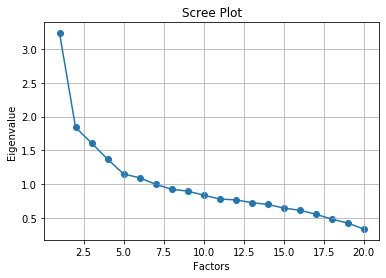

In [16]:
# Create scree plot using matplotlib
plt.scatter(range(1,factor_df.shape[1]+1),ev)
plt.plot(range(1,factor_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

It looks like 6 is the best amount of factors

In [17]:
fa = FactorAnalyzer(n_factors=6, method='principal',rotation='varimax')
fa.fit(factor_df)
loadings = fa.loadings_

loadings_df = pd.DataFrame(loadings)
loadings_df = loadings_df.set_index(factor_df.columns)

def color_loading(val):
    color = 'cyan' if abs(val) >= 0.3 else 'white'
    return 'color: %s' % color

loadings_df = loadings_df.style.applymap(color_loading)
loadings_df

,0,1,2,3,4,5
V8,0.203152,-0.266567,0.165667,0.171087,0.586672,0.039731
V47,0.087218,0.282664,0.024079,0.025607,0.058586,0.644558
V59,0.643018,0.346871,-0.190689,-0.010907,0.249882,-0.075256
V71,-0.278504,0.178307,-0.129800,-0.061560,0.588289,0.202184
V96,0.124886,0.312994,0.057109,-0.017918,-0.075170,-0.563313
V121,-0.096947,-0.262050,0.325622,-0.149332,-0.045150,0.326654
V181,0.284502,0.095373,0.005883,0.049442,0.718338,-0.094316
V229,-0.233909,-0.147973,-0.008484,0.519484,0.227533,-0.296461
V235,0.077949,-0.011292,-0.081734,0.802159,-0.104009,0.124344
V236,-0.036259,-0.043942,0.093262,0.762611,0.082362,-0.017998


Some of the variables are cross loading into multiple factors. I am going to remove these variables.

In [18]:
factor_df = factor_df.drop(['V59', 'V121', 'V49'], axis=1)
fa = FactorAnalyzer(n_factors=6, method='principal',rotation='varimax')
fa.fit(factor_df)
loadings = fa.loadings_

loadings_df = pd.DataFrame(loadings)
loadings_df = loadings_df.set_index(factor_df.columns)

loadings_df = loadings_df.style.applymap(color_loading)
loadings_df

,0,1,2,3,4,5
V8,-0.172536,-0.238742,0.135223,0.662739,0.135411,-0.048308
V47,-0.097496,0.212788,-0.004704,0.051254,0.040044,-0.699934
V71,0.363809,0.188550,-0.065356,0.510914,-0.130642,-0.279568
V96,-0.139986,0.364597,0.004193,-0.060936,0.048071,0.536372
V181,-0.213616,0.157579,0.027446,0.764466,-0.021079,0.046835
V229,0.240977,-0.122313,0.511510,0.260029,-0.007312,0.310776
V235,-0.085324,-0.022349,0.818551,-0.107190,-0.074035,-0.130587
V236,0.041804,-0.039233,0.766080,0.099614,0.093637,0.034656
V237,0.569702,-0.041439,0.131717,-0.243140,0.046889,-0.020569
V238,0.813998,-0.170413,-0.002530,-0.060435,0.074967,0.035468


Now I am going to add factor scores to the dataset and remove the columns that were used to create the scores

In [19]:
# Get factor scores from the fit above
factor_scores = pd.DataFrame(fa.transform(factor_df))
# name the factors based on the variables that loaded into the values above
factor_scores.columns = ['Income_f', 'Health_Independence_f', 'Employement_f', 'Money_Concern_f','Family_f', 'Income_Equality_f' ]

#drop columns that went into factors
drop_columns = list(loadings_df.index.values)
model_df = model_df.drop(drop_columns, axis=1)

# add factors to the dataset
model_df = pd.concat([model_df, factor_scores],axis=1,sort=False)

## Model Building ##

In [20]:
# Create train data and test data
x_train, x_test, y_train, y_test = train_test_split(model_df, target, train_size=0.75)
print("Training data shapes", x_train.shape, y_train.shape)
print("Testing data shapes", x_test.shape, y_test.shape)

Training data shapes (1662, 143) (1662,)
Testing data shapes (554, 143) (554,)


 ### What features are important for the predictor? ### 
When running the above feature importance we get these ten values as being the most important predictors for the random forest model.

In [21]:
# Training the Model
rf_model = RandomForestRegressor(n_estimators=500)
rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
# a blank dictionary to hold feature_name: feature_importance
feats = {} 
#create dictionary
for feature, importance in zip(x_train.columns, rf_model.feature_importances_):
    feats[feature] = importance #add the key and value

# turn importances to dataframe and sort by importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False)

importances.head(10)

,Gini-importance
V59,0.262627
Health_Independence_f,0.135327
Family_f,0.053562
V56,0.024128
Income_Equality_f,0.019803
Income_f,0.019751
Money_Concern_f,0.017748
Employement_f,0.017457
V242,0.017229
V249,0.011376


### Permutation Importance ###
I found another measure of feature importance for testing which variables are important in predicting variable V23(life satisfaction). This code came from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://www.youtube.com/watch?v=ttBs_wfw_6U

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
top10 = sorted_idx[:10]

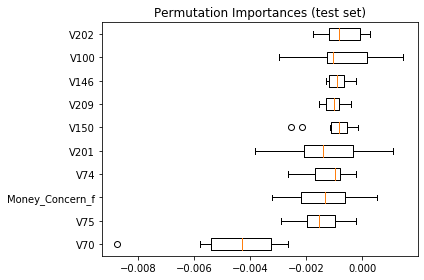

In [24]:
#Graph for Permutation Importance
fig, ax = plt.subplots()
ax.boxplot(result.importances[top10].T, vert=False, labels=x_test.columns[top10])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

I am a bit unfamiliar with permutation importance so I did not use these results like I did with the Gini Importance. Still wanted to include the code as an example though.

### Random Forest Model ###
Now that I have selected features, I am going to create a random forest model to predict V23. One of the models is just going to use the top ten predictors and one is going to be a black box model of all the variables.

In [25]:
# Training the blackbox model with all columns
rf_model_all = RandomForestRegressor(n_estimators=500)
rf_model_all.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [26]:
top10_list = list(importances.index.values[0:10])
top10_model_df = model_df[top10_list]
# Create train data and test data
x_train2, x_test2, y_train2, y_test2 = train_test_split(top10_model_df, target, train_size=0.75)

# Training the top 10 important variable Model
rf_model = RandomForestRegressor(n_estimators=500)
rf_model.fit(x_train2, y_train2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Logistic Regression Model ### 
I am going to classify V23 into three separate categories, unsatisfied, neutral, and satisfied with life. Then I am going to make a logistic regression model to predict these categories using the top 10 variables from before since logistic can't run a blackbox model.

Text(0.5, 1.0, 'Histogram of V23')

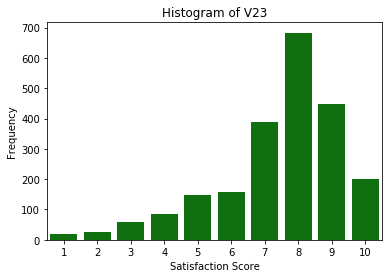

In [27]:
ax = sns.countplot(x="V23", data=df, color='green')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.title('Histogram of V23')

In [28]:
binned_target = target.copy(deep=True)

binned_target.loc[(binned_target<6)] = 0
binned_target.loc[(binned_target>=6) & (binned_target<=8)] = 1
binned_target.loc[(binned_target>8)] = 2
binned_target.name

'V23'

Text(0.5, 1.0, 'Histogram of Binned V23')

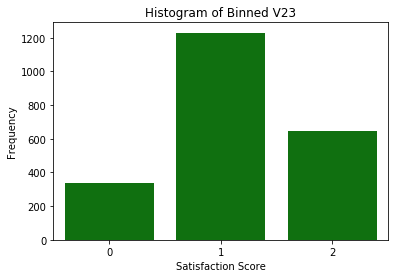

In [29]:
ax = sns.countplot(x=binned_target, color='green')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.title('Histogram of Binned V23')

In [30]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(top10_model_df, binned_target, train_size=0.75)

logistic_model = LogisticRegression(max_iter=1000).fit(x_train3, y_train3)

## Accuracy ##
Now that the models are trained I am going to run them on the testing datasets and see how they perform. At first I am doing confusion matrices.

Random Forest Black Box Model
Confusion Matrix :
[[ 0  0  0  0  1  1  0  1  1  0]
 [ 0  0  0  0  3  2  3  1  1  0]
 [ 0  0  1  1  4  7  2  1  1  0]
 [ 0  0  0  1  5 10  7  2  0  0]
 [ 0  0  0  0  8 12 11  2  0  0]
 [ 0  0  0  1  1 16 16 10  0  0]
 [ 0  0  0  1  3 20 26 40  1  0]
 [ 0  0  0  0  2 15 43 91 21  0]
 [ 0  0  0  0  0  2 14 66 26  0]
 [ 0  0  0  0  0  4  5 15 21  5]]
Accuracy Score : 0.3140794223826715
Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        10
           3       1.00      0.06      0.11        17
           4       0.25      0.04      0.07        25
           5       0.30      0.24      0.27        33
           6       0.18      0.36      0.24        44
           7       0.20      0.29      0.24        91
           8       0.40      0.53      0.45       172
           9       0.36      0.24      0.29       108
          10       1.00      0.10

C:\Users\Hawkin Saeger\Anaconda3\envs\independent_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



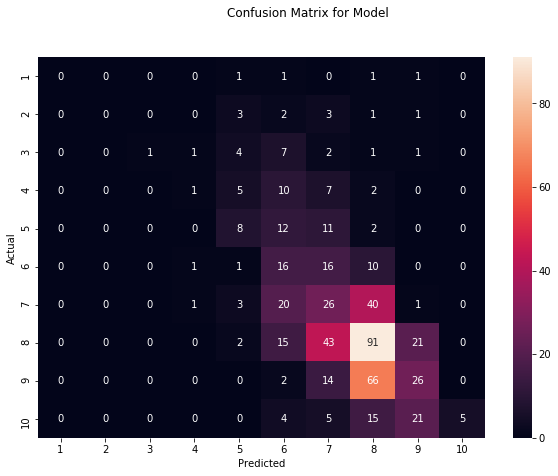

##############################################################################
Random Forest Top 10 Model
Confusion Matrix :
[[ 0  0  0  0  2  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  1  5  2  4  0  0  0]
 [ 0  0  1  3  9  8  2  0  0  0]
 [ 0  0  0  1  6  7 10  3  1  0]
 [ 0  0  0  1  1 17 16  8  0  0]
 [ 0  0  0  1  9 18 39 34  5  0]
 [ 0  0  0  1  6 17 46 95 20  0]
 [ 0  0  0  0  0  3 23 50 24  2]
 [ 0  0  0  0  0  0  6 16 24  5]]
Accuracy Score : 0.34115523465703973
Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        12
           4       0.38      0.13      0.19        23
           5       0.16      0.21      0.18        28
           6       0.24      0.40      0.30        43
           7       0.27      0.37      0.31       106
           8       0.46      0.51      0.49       185
          

C:\Users\Hawkin Saeger\Anaconda3\envs\independent_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



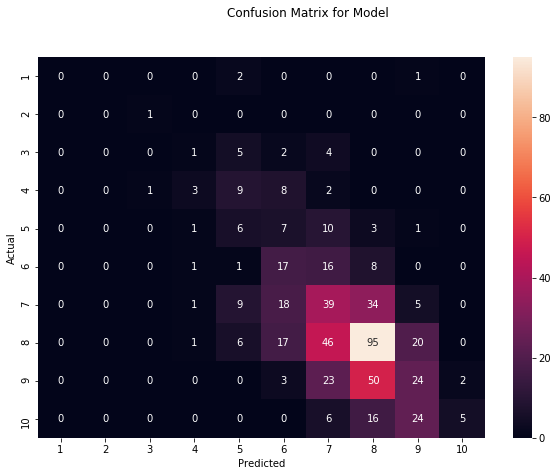

##############################################################################
Logistic Regression Model 
Confusion Matrix :
[[ 29  47   5]
 [ 20 252  47]
 [  2  66  86]]
Accuracy Score : 0.6624548736462094
Report : 
              precision    recall  f1-score   support

           0       0.57      0.36      0.44        81
           1       0.69      0.79      0.74       319
           2       0.62      0.56      0.59       154

    accuracy                           0.66       554
   macro avg       0.63      0.57      0.59       554
weighted avg       0.65      0.66      0.65       554



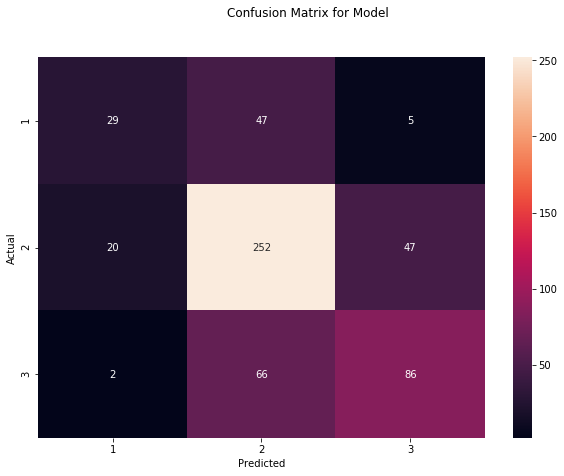

In [31]:
# define formula for an accuracy check
def accuracy_check(model, test, actual):
    # get predictions
    predicted = model.predict(test)
    #round before converting
    predicted = np.around(predicted)
    #convert from float to int
    predicted = predicted.astype(int)

    # get confusion matrix
    results = confusion_matrix(actual, predicted)
    print('Confusion Matrix :')
    print(results) 
    print('Accuracy Score :',accuracy_score(actual, predicted))
    print('Report : ')
    print(classification_report(actual, predicted)) 
    plt.figure(figsize = (10,7))
    ticks = np.arange(1,len(results)+1,1)
    sns.heatmap(results, annot=True, xticklabels=ticks, yticklabels=ticks, fmt='g')
    plt.suptitle("Confusion Matrix for Model")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
# Random Forest Blackbox:
print("Random Forest Black Box Model")
accuracy_check(rf_model_all, x_test, y_test)
#Random Forest Top 10
print("##############################################################################")
print("Random Forest Top 10 Model")
accuracy_check(rf_model, x_test2, y_test2)
#logistic regression top 10
print("##############################################################################")
print("Logistic Regression Model ")
accuracy_check(logistic_model, x_test3, y_test3)

 ## More Accuracies for Random Forest Regressors ##
 As you can see both the random forest models have really low accuracy. That is because it is extremely hard to predict the exact number when you are looking at 10 categories instead of 3 like the logistic model. I left the matrices in because it is still beneficial to see where the model is predicting values and where potential improvements could be made. Even though it wasn't always correct most numbers are very close to the diagonal portion where the correct numbers are. 
 
 I am going to do some other metrics for these two models to show performance below.

In [49]:
# Random Forest blackbox
print("Random Forest Black Box Model")
predicted = rf_model_all.predict(x_test)
actual = y_test
print("Root Mean Squared Error", mean_squared_error(actual, predicted, squared=False))
print("Mean Squared Error", mean_squared_error(actual, predicted))
print("R Squared", r2_score(actual, predicted))

# Calculate the absolute errors
errors = abs(predicted - actual)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / actual)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


#Random Forest Top 10
print("\n##############################################################################\n")
print("Random Forest Top 10 Model")
predicted = rf_model.predict(x_test2)
actual = y_test2
print("Root Mean Squared Error", mean_squared_error(actual, predicted, squared=False))
print("Mean Squared Error", mean_squared_error(actual, predicted))
print("R Squared", r2_score(actual, predicted))

# Calculate the absolute errors
errors = abs(predicted - actual)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / actual)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Random Forest Black Box Model
Root Mean Squared Error 1.5429904435949273
Mean Squared Error 2.3808195090252706
R Squared 0.3536459992658202
Mean Absolute Error: 1.1 degrees
Accuracy: 75.91 %.

##############################################################################

Random Forest Top 10 Model
Root Mean Squared Error 1.3318185986775353
Mean Squared Error 1.7737407797833935
R Squared 0.37541154321549985
Mean Absolute Error: 1.01 degrees
Accuracy: 82.38 %.
